# Forecasting Public Transport Ridership - Bus and Rail services


`Dataset`

[Ridership - Daily Boarding Totals](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97): This dataset shows systemwide boardings for both bus and rail services provided by Chicago Transit Authority, dating back to 2001.

`Objective`:
The goal is to forecast future transit ridership in the City of Chicago.

### Content

Dataset
1. Data Exploration
    1. Visualization
    2. Seasonality
    3. Auto-correlation


2. Model
    1. Utility functions
    2. Preparing data
    3. LSTM
    4. CNN
    5. Ensemble ML Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(rc={'figure.figsize':(16,4)})

2024-03-22 20:49:26.298148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 20:49:26.298298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 20:49:26.436967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [3]:
target = 'total_rides'
ts_col = 'service_date'
raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'

df = pd.read_csv(raw_data_file, index_col=[ts_col], parse_dates=[ts_col])
print(df.shape)
df.head()

(8401, 4)


day_type     bus  rail_boardings  total_rides
service_date                                              
2001-01-01          U  297192          126455       423647
2001-01-02          W  780827          501952      1282779
2001-01-03          W  824923          536432      1361355
2001-01-04          W  870021          550011      1420032
2001-01-05          W  890426          557917      1448343

In [4]:
df = df[df.index < '2020-01-01']  # only data before 2020
df = df.drop_duplicates()
df = df.sort_index()
print(df.shape)
df.head()

(6939, 4)


day_type     bus  rail_boardings  total_rides
service_date                                              
2001-01-01          U  297192          126455       423647
2001-01-02          W  780827          501952      1282779
2001-01-03          W  824923          536432      1361355
2001-01-04          W  870021          550011      1420032
2001-01-05          W  890426          557917      1448343

# 1 Data Exploration

## 1.1 Visualization

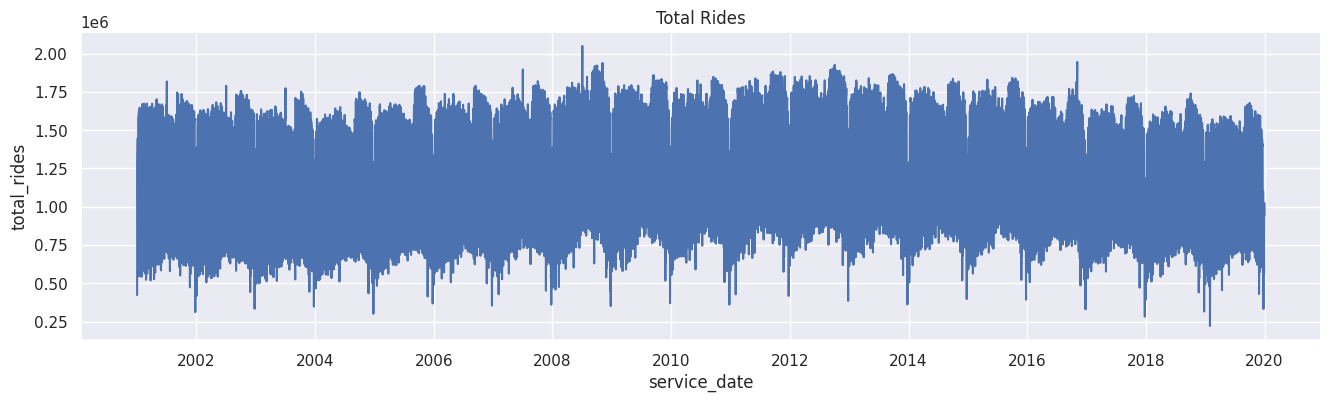

In [5]:
# Explore total rides over time
sns.lineplot(data=df, x=df.index, y=df[target]).set_title('Total Rides')
fig = plt.show()

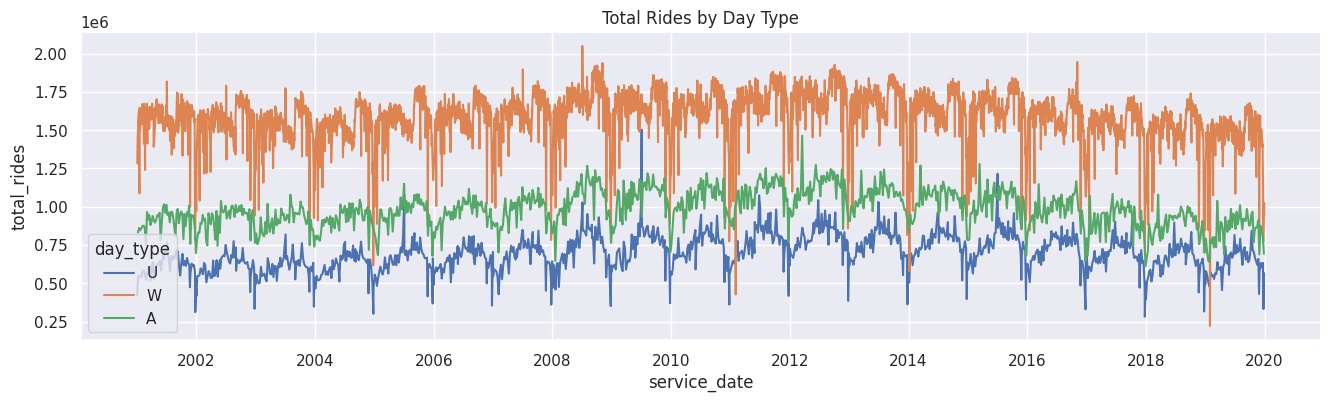

In [6]:
# Explore rides by day type: Weekday (W), Saturday (A), Sunday/Holiday (U)
sns.lineplot(data=df, x=df.index, y=df[target], hue=df['day_type']).set_title('Total Rides by Day Type')
fig = plt.show()

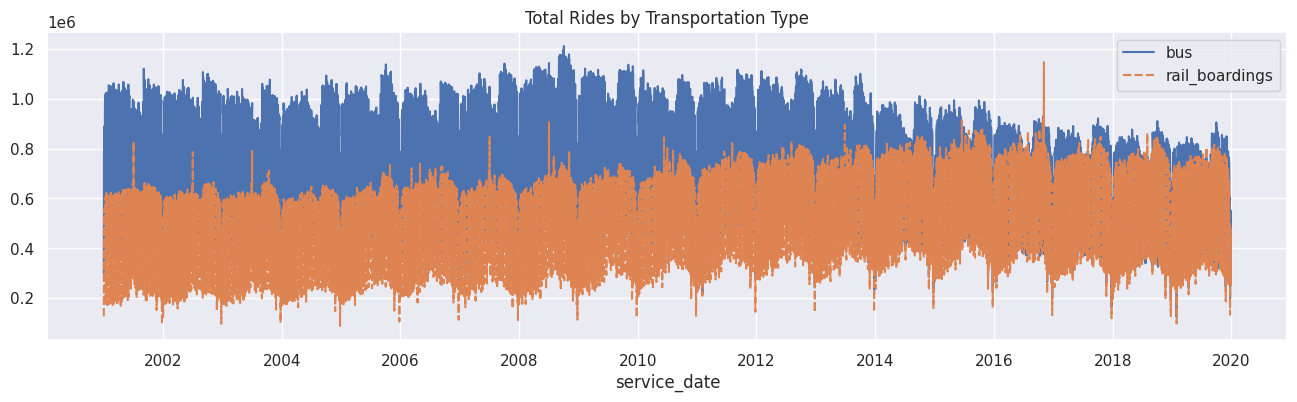

In [7]:
# Explore rides by transportation type
sns.lineplot(data=df[['bus','rail_boardings']]).set_title('Total Rides by Transportation Type')
fig = plt.show()

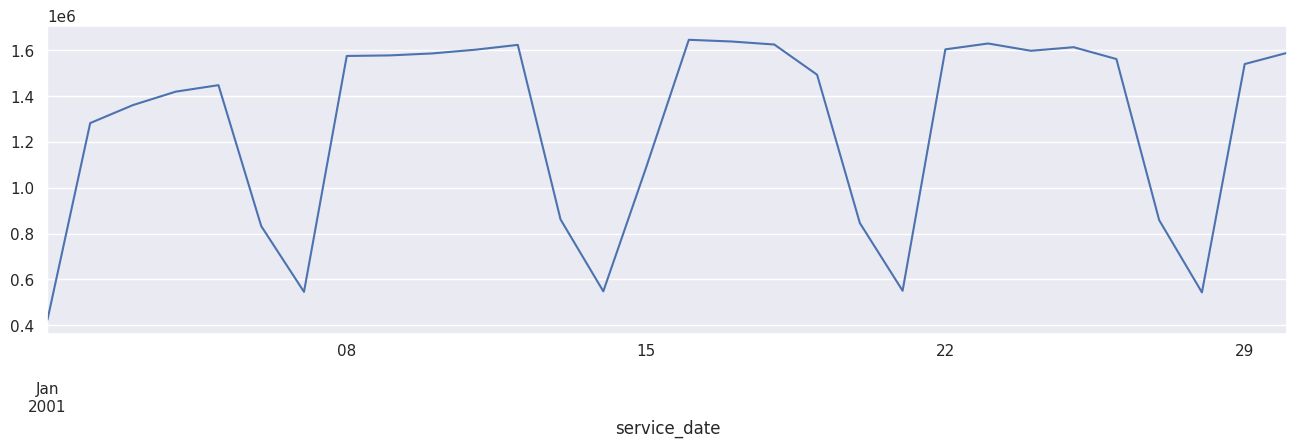

In [8]:
# Plot 30 days of ridership
_ = df[target][:30].plot()

In [9]:
# Summary statistics like average number of riders per day
df[target].describe().apply(lambda x: round(x))

count       6939
mean     1368761
std       391443
min       222071
25%      1005394
50%      1548343
75%      1660947
max      2049519
Name: total_rides, dtype: int64

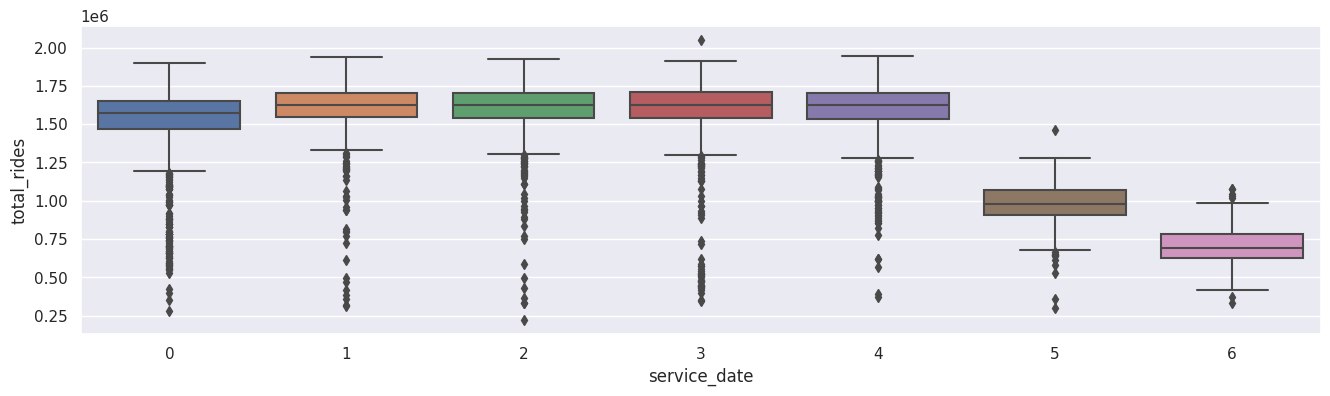

In [10]:
# distribution of values for each day of the week in a boxplot
# Min, 25th percentile, median, 75th percentile, max 
daysofweek = df.index.to_series().dt.dayofweek
fig = sns.boxplot(x=daysofweek, y=df[target])

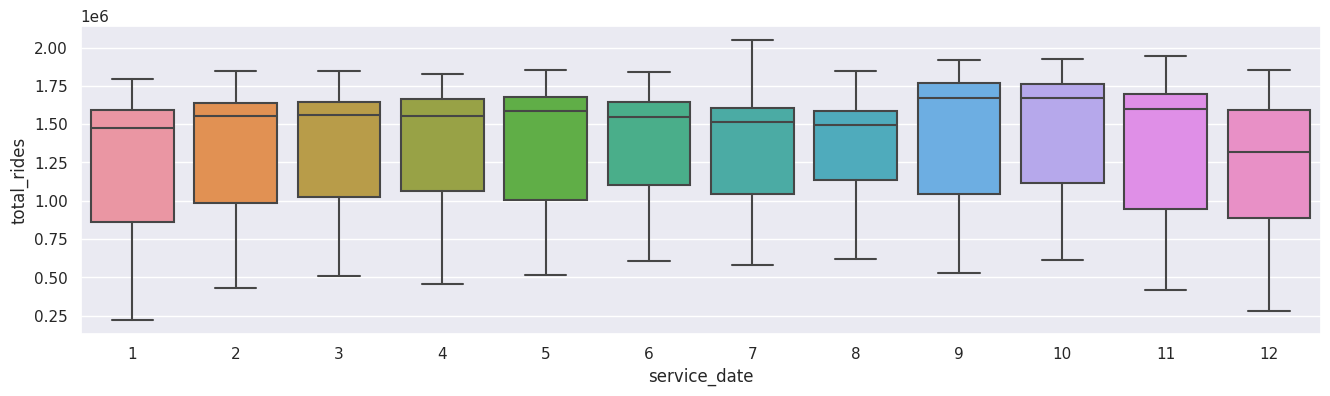

In [11]:
# Distribution of values for each month in a boxplot
months = df.index.to_series().dt.month
fig = sns.boxplot(x=months, y=df[target])

## 1.2 Seasonality

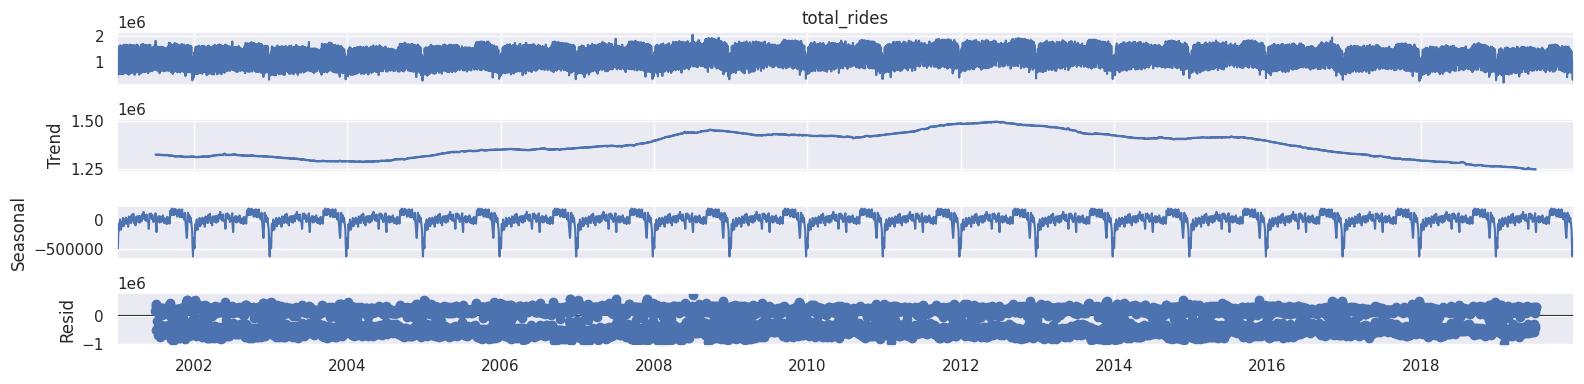

In [12]:
# Decompose the data into trend and seasonal components
result = seasonal_decompose(df[target], period=365)
fig = result.plot()

- There is annual seasonality and there is no trends.

## 1.3 Auto-correlation

Create an auto-correlation plot to show how correlated a time-series is with itself. Each point on the y-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

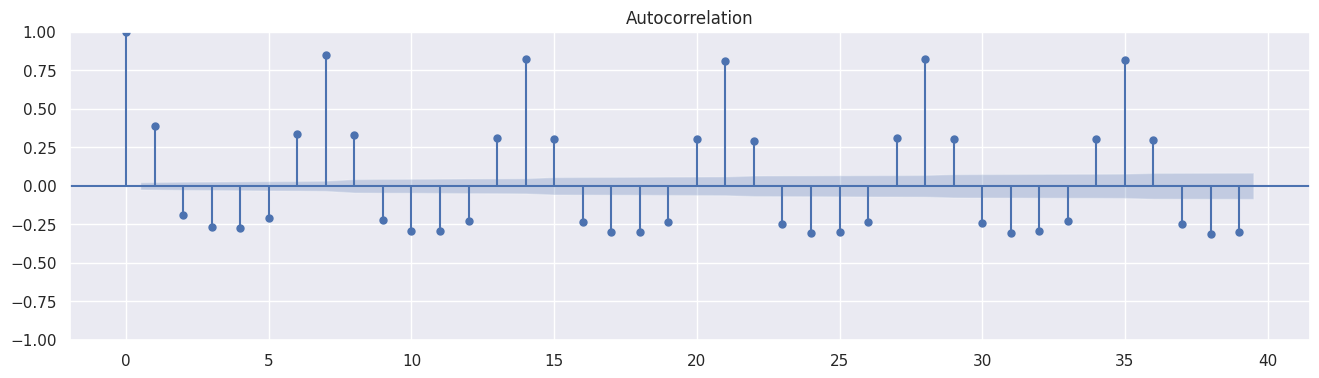

In [13]:
plot_acf(df[target])
fig = plt.show()

- The correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

In [14]:
# Export data
processed_file = './cta_ridership.csv'
df[[target]].to_csv(processed_file, index=True, index_label=ts_col)

In [15]:
gc.collect()

45589

# 2 Model

In [16]:
# Model parameters
freq = 'D' # daily frequency
n_input_steps = 30 # lookback window
n_output_steps = 7 # how many steps to predict forward
n_seasons = 7 # monthly periodicity
train_split = 0.8
epochs = 1000
patience = 5

In [17]:
# Dataset
input_file = './cta_ridership.csv'
df = pd.read_csv(input_file, index_col=ts_col, parse_dates=True)
df.index.freq = freq
print(df.shape)
df.head()

(6939, 1)


total_rides
service_date             
2001-01-01         423647
2001-01-02        1282779
2001-01-03        1361355
2001-01-04        1420032
2001-01-05        1448343

In [18]:
# Some characteristics of the data that will be used later
n_features = len(df.columns)
target_col_num = df.columns.get_loc(target)  # index of target column

## 2.1 Utility functions

In [19]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def scale(df, 
          fit=True, 
          target_col=target,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    """
    Scale the input features, using a separate scaler for the target.
    
    Parameters: 
    df (pd.DataFrame): Input dataframe
    fit (bool): Whether to fit the scaler to the data (only apply to training data)
    target_col (pd.Series): The column that is being predicted
    feature_scaler (StandardScaler): Scaler used for features
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    df_scaled (pd.DataFrame): Scaled dataframe   
    """    
    
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    target_scaled = target_scaler.transform(target)
    
    # Select all columns other than target to be features
    features = df.loc[:, df.columns != target_col].values
    
    if features.shape[1]:  # If there are any features
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        
        # Combine target and features into one data frame
        df_scaled = pd.DataFrame(features_scaled)
        target_col_num = df.columns.get_loc(target_col)
        df_scaled.insert(target_col_num, target, target_scaled)
        df_scaled.columns = df.columns        
    
    else:  # If only target column (no additional features)
        df_scaled = pd.DataFrame(target_scaled, columns=df.columns)
      
    return df_scaled

def inverse_scale(data, target_scaler=target_scaler):
    """
    Transform the scaled values of the target back into their original form.
    The features are left alone, as we're assuming that the output of the model only includes the target.
    
    Parameters: 
    data (np.array): Input array
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    data_scaled (np.array): Scaled array   
    """
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = target_scaler.inverse_transform([data[:,i]])
    return data_scaled.transpose()

In [20]:
def reframe(data, n_input_steps=n_input_steps, n_output_steps=n_output_steps, target_col=target):

    target_col_num = data.columns.get_loc(target_col)    
    
    # Iterate through data and create sequences of features and outputs
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i).rename(columns={"total_rides": f"lag_{i}"}))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenate values and remove any missing values
    df = pd.concat(cols, axis=1)
    df.dropna(inplace=True)
    
    # Split the data into feature and target variables
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols + target_col_num,
                                    n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

In [21]:
# Evaluate result
def print_stats(timestep, y_true, y_pred, target_col, chart=True, table=False, dec=3):
    '''
    Helper function to print overall summary statistics and stats for each time step
    '''
    # Print summary statistics
    print('=== t+' + str(timestep) + ' ===')
    print('R^2:  ' + str(np.round(r2_score(y_true, y_pred), dec)))
    print('MAPE: ' + str(np.round(mean_absolute_percentage_error(y_true, y_pred), dec)))
    print('MAE:  ' + str(np.round(mean_absolute_error(y_true, y_pred), dec)))
    print('')
    df_y_true = pd.DataFrame(y_true)
    df_y_true[target_col + '_pred'] = np.round(y_pred, dec)
    
    # Show plot of actuals vs predictions and a sample of values
    if table:
        print(str(df_y_true.head(5)) + '\n')
        print(str(df_y_true.tail(5)) + '\n')
    if chart:
        sns.lineplot(data=df_y_true[[target_col, target_col+'_pred']])
        plt.show()
        
def evaluate(y_pred, y_true,
             exclude_timesteps=n_input_steps,
             target_col=target):
    '''
    Helper function to transform predictions to match size and indices of actuals.
    
    For example, n_timesteps from the test data will be required to make a prediction,
    so the number of predictions will be fewer than the number of test samples.
    
    Parameters:
    y_pred (np.array): Predictions
    exclude_timesteps (int): Number of leading timesteps to trim from the dataset
    y_true (pd.DataFrame): Actuals
    '''     
    # Number of outputs (future timesteps)
    outputs = y_pred.shape[1]
    
    target_col_num = df.columns.get_loc(target_col)
    
    # Lists of actual and predicted values for each time step
    # For example, y_true_eval[2] will contain actual values 3 time steps out
    # These specific lists enable computing the accuracy for specific time steps
    y_true_eval, y_pred_eval = list(), list()

    # Actual and predicted values combined across all time steps (to compute overall accuracy metrics)
    y_true_all, y_pred_all = np.array([]), np.array([])
    
    # Append entries to lists for each output timestep
    for t in range(outputs):
        if exclude_timesteps:
            y_true_eval.append(y_true[exclude_timesteps+t:len(y_true)-outputs+t+1].copy())
            y_pred_eval.append(y_pred[:,t])          
        else:
            y_true_eval.append(y_true[t:].copy())
            y_pred_eval.append(y_pred[:-1*t-1,t])
        # Append the output values to the combined lists
        y_true_all = np.concatenate([y_true_all, y_true_eval[t].values[:,target_col_num]], axis=0)
        y_pred_all = np.concatenate([y_pred_all, y_pred_eval[t]], axis=0)

    # Print aggregate statistics across all time steps (only if predicting multiple time steps)
    if outputs > 1:
        print_stats('(1-' + str(outputs) + ')', y_true_all, y_pred_all, target_col, False)

    # Print stats for each future time step
    for t in range(outputs):    
        print_stats(t+1, y_true_eval[t][target_col], y_pred_eval[t], target_col, True)

## 2.2 Preparing data

In [22]:
# Split
size = int(len(df) * train_split)
df_train, df_test = df[0:size].copy(deep=True), df[size:len(df)].copy(deep=True)
df_train.head()

total_rides
service_date             
2001-01-01         423647
2001-01-02        1282779
2001-01-03        1361355
2001-01-04        1420032
2001-01-05        1448343

In [23]:
# Scale
df_train_scaled = scale(df_train)
df_test_scaled = scale(df_test, False)
df_train_scaled.head()

total_rides
0    -2.442494
1    -0.262138
2    -0.062724
3     0.086190
4     0.158040

In [38]:
# Reframe
X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)
X_train_reframed.head()

lag_30    lag_29    lag_28    lag_27    lag_26    lag_25    lag_24  \
30 -2.442494 -0.262138 -0.062724  0.086190  0.158040 -1.404230 -2.132852   
31 -0.262138 -0.062724  0.086190  0.158040 -1.404230 -2.132852  0.481830   
32 -0.062724  0.086190  0.158040 -1.404230 -2.132852  0.481830  0.487806   
33  0.086190  0.158040 -1.404230 -2.132852  0.481830  0.487806  0.509769   
34  0.158040 -1.404230 -2.132852  0.481830  0.487806  0.509769  0.550699   

      lag_23    lag_22    lag_21  ...    lag_10     lag_9     lag_8     lag_7  \
30  0.481830  0.487806  0.509769  ... -2.120589  0.554884  0.619909  0.539107   
31  0.487806  0.509769  0.550699  ...  0.554884  0.619909  0.539107  0.578794   
32  0.509769  0.550699  0.604434  ...  0.619909  0.539107  0.578794  0.447406   
33  0.550699  0.604434 -1.330404  ...  0.539107  0.578794  0.447406 -1.337848   
34  0.604434 -1.330404 -2.127073  ...  0.578794  0.447406 -1.337848 -2.138951   

       lag_6     lag_5     lag_4     lag_3     lag_2     lag_1  
30  0.578794  0.447406 -1.337848 -2.138951  0.392134  0.517301  
31  0.447406 -1.337848 -2.138951  0.392134  0.517301  0.568048  
32 -1.337848 -2.138951  0.392134  0.517301  0.568048  0.720259  
33 -2.138951  0.392134  0.517301  0.568048  0.720259  0.401991  
34  0.392134  0.517301  0.568048  0.720259  0.401991 -1.296224  

[5 rows x 30 columns]

In [39]:
# Reshape test data to match model inputs and outputs
X_train = X_train_reframed.values.reshape(-1, n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(-1, n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(-1, n_output_steps, 1)
y_test = y_test_reframed.values.reshape(-1, n_output_steps, 1)

X_train[0]

array([[-2.44249359],
       [-0.26213841],
       [-0.06272367],
       [ 0.08619024],
       [ 0.15803954],
       [-1.40423043],
       [-2.13285205],
       [ 0.48182964],
       [ 0.4878063 ],
       [ 0.50976892],
       [ 0.5506995 ],
       [ 0.60443357],
       [-1.33040413],
       [-2.12707334],
       [-0.75647512],
       [ 0.66101004],
       [ 0.64198372],
       [ 0.6084713 ],
       [ 0.27344103],
       [-1.3702079 ],
       [-2.12058912],
       [ 0.55488442],
       [ 0.61990943],
       [ 0.53910656],
       [ 0.57879359],
       [ 0.44740613],
       [-1.33784767],
       [-2.13895052],
       [ 0.39213412],
       [ 0.51730128]])

## 2.3 LSTM

In [29]:
# For using gpu
strategy = tf.distribute.MirroredStrategy()

In [35]:
%%time
lstm_n_units = 90
with strategy.scope():
    tf.keras.utils.set_random_seed(1)
    lstm_model = Sequential([
        LSTM(lstm_n_units, input_shape=[n_input_steps, n_features]),
        Dense(n_output_steps)
    ])
    lstm_model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
lstm_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
               epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7276 - val_loss: 0.3409
Epoch 2/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3124 - val_loss: 0.2646
Epoch 3/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2394 - val_loss: 0.2451
Epoch 4/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2278 - val_loss: 0.2459
Epoch 5/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2210 - val_loss: 0.2378
Epoch 6/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2161 - val_loss: 0.2307
Epoch 7/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2123 - val_loss: 0.2295
Epoch 8/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2087 - val_loss: 0.2242
Epoch 9/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2056 - val_loss: 0.2229
Epoch 10/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2032 - val_loss: 0.2225
Epoch 11/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2019 - val_loss: 0.2188
Epoch 12/1000
173/173 ━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=== t+(1-7) ===
R^2:  0.818
MAPE: 0.089
MAE:  78554.146

=== t+1 ===
R^2:  0.85
MAPE: 0.079
MAE:  67850.922



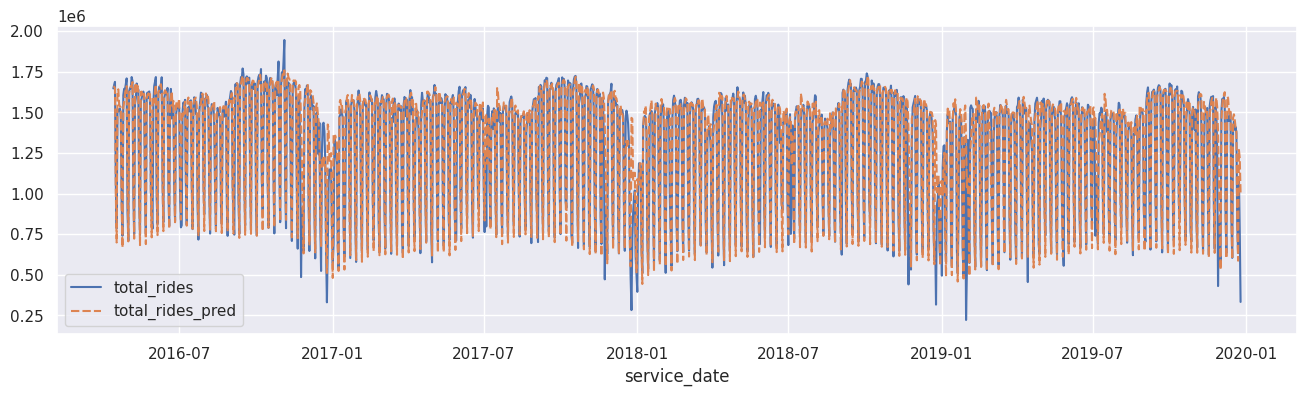

=== t+2 ===
R^2:  0.823
MAPE: 0.087
MAE:  75928.73



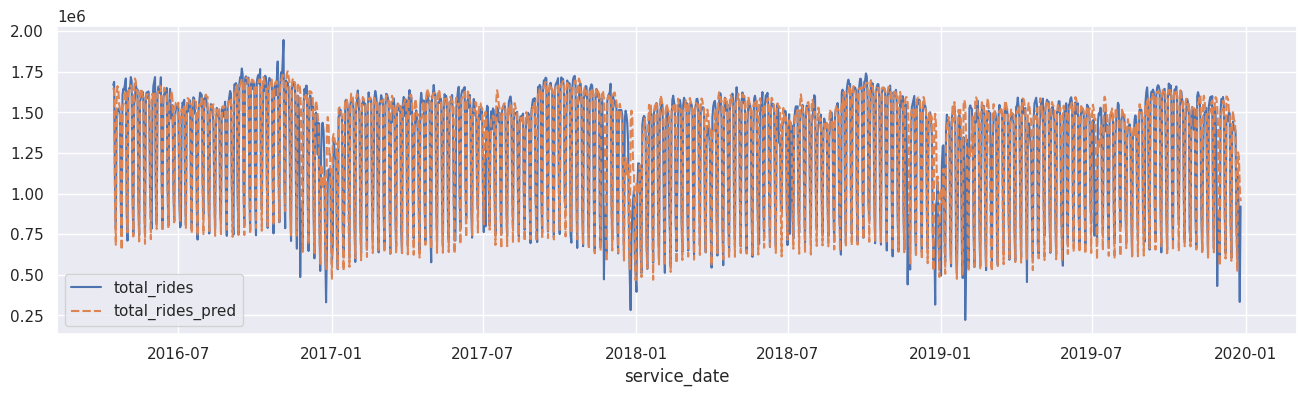

=== t+3 ===
R^2:  0.814
MAPE: 0.09
MAE:  78888.556



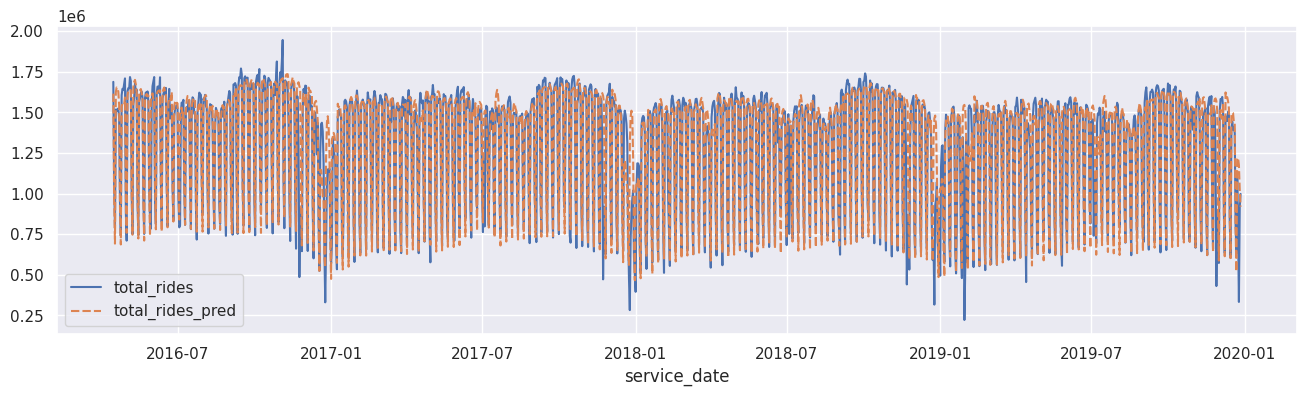

=== t+4 ===
R^2:  0.805
MAPE: 0.093
MAE:  82059.294



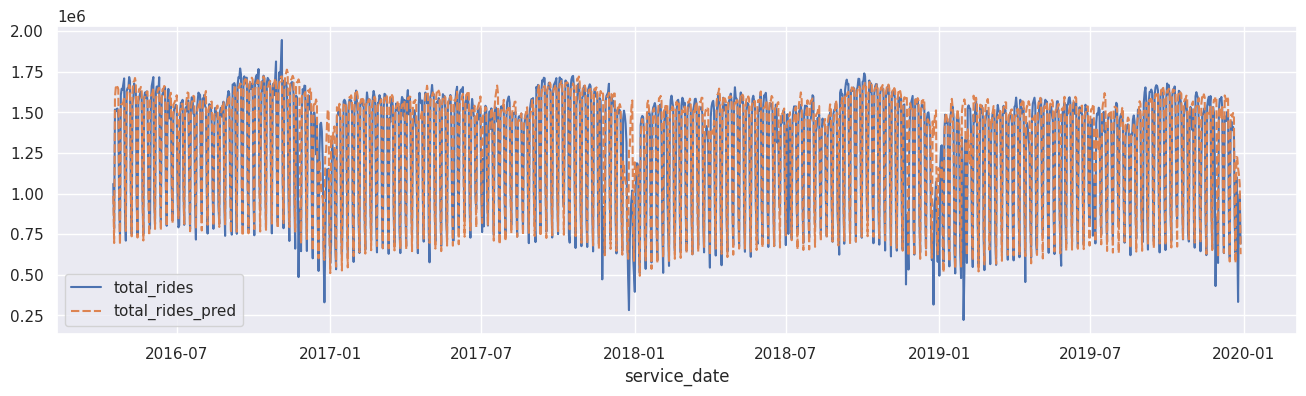

=== t+5 ===
R^2:  0.808
MAPE: 0.093
MAE:  82040.52



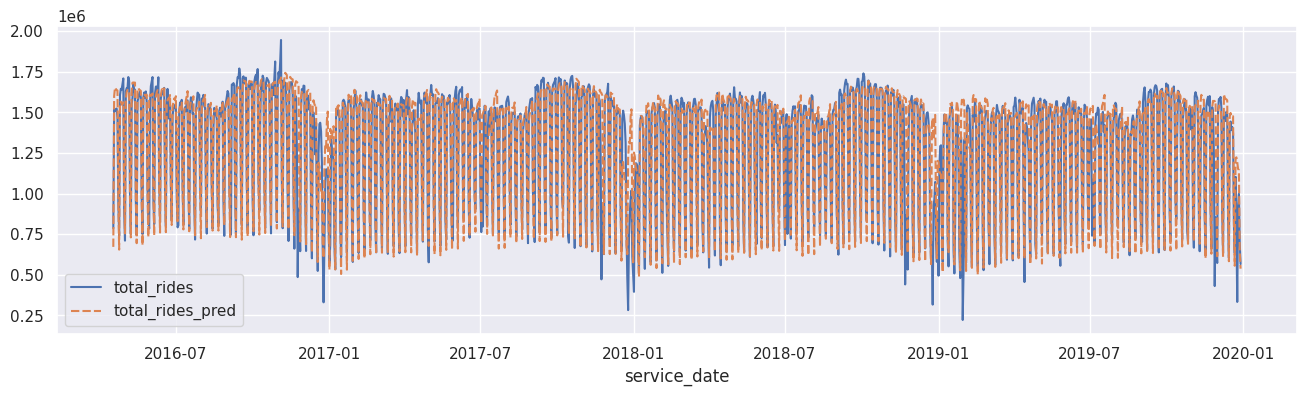

=== t+6 ===
R^2:  0.815
MAPE: 0.093
MAE:  82437.519



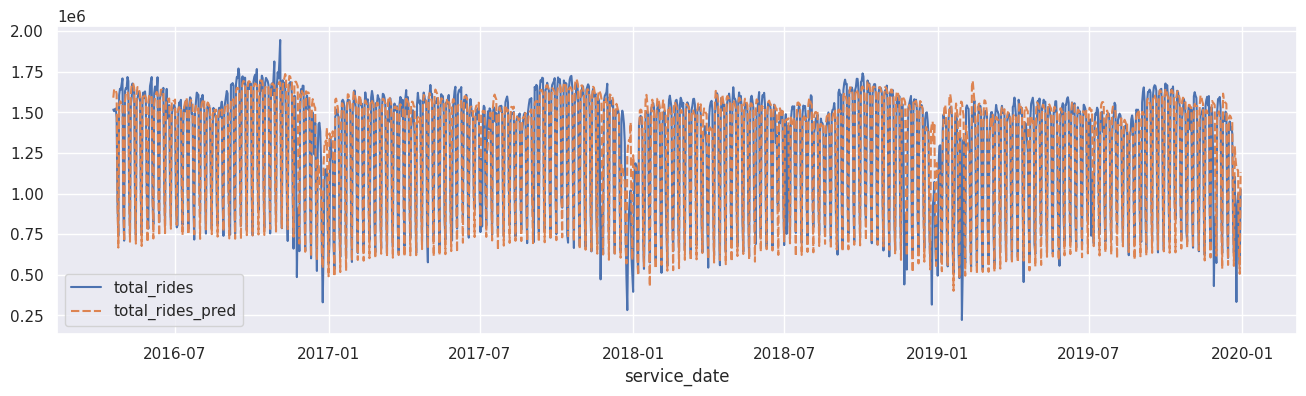

=== t+7 ===
R^2:  0.809
MAPE: 0.092
MAE:  80673.48



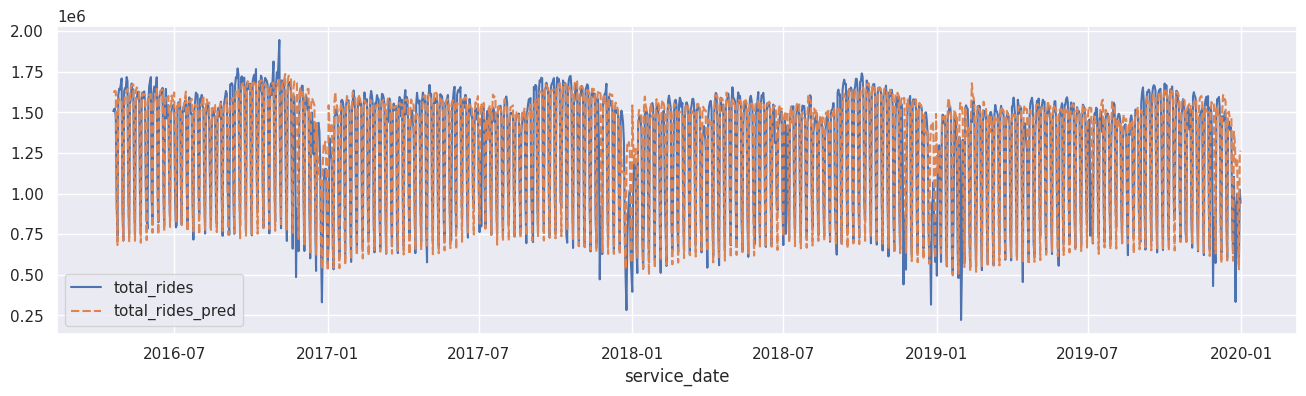

In [36]:
# Predict the results, and then reverse the transformation that scaled all values to a mean of 0 and std. dev. of 1
preds = lstm_model.predict(X_test)
y_pred_lstm = inverse_scale(preds)

# Evaluate the overall results and for each time step
evaluate(y_pred_lstm, df_test)

In [98]:
tf.saved_model.save(lstm_model, './lstm_export')

## 2.4 CNN

In [37]:
%%time
n_filters = 60
kernel_size = 7

tf.keras.utils.set_random_seed(1)
cnn_model = Sequential([
    Conv1D(filters=n_filters, kernel_size=kernel_size, input_shape=[n_input_steps, n_features]),
    Flatten(),
    Dense(n_output_steps)])

cnn_model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
_ = cnn_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                  epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
107/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4231

I0000 00:00:1711121432.089553      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3769 - val_loss: 0.2698
Epoch 2/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2538 - val_loss: 0.2651
Epoch 3/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2505 - val_loss: 0.2611
Epoch 4/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2487 - val_loss: 0.2602
Epoch 5/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2476 - val_loss: 0.2606
Epoch 6/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2477 - val_loss: 0.2598
Epoch 7/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2469 - val_loss: 0.2602
Epoch 8/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2470 - val_loss: 0.2592
Epoch 9/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2466 - val_loss: 0.2588
Epoch 10/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2468 - val_loss: 0.2589
Epoch 11/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2468 - val_loss: 0.2586
Epoch 12/1000
173/173 ━━━━━━━━━━━━━━━━━━━━ 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== t+(1-7) ===
R^2:  0.766
MAPE: 0.104
MAE:  96856.925

=== t+1 ===
R^2:  0.808
MAPE: 0.094
MAE:  87594.651



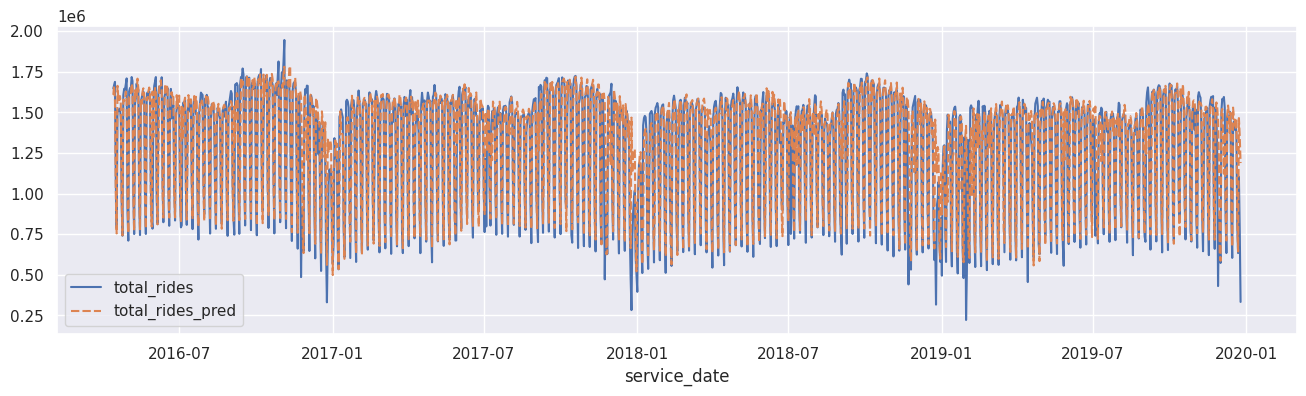

=== t+2 ===
R^2:  0.769
MAPE: 0.102
MAE:  95281.019



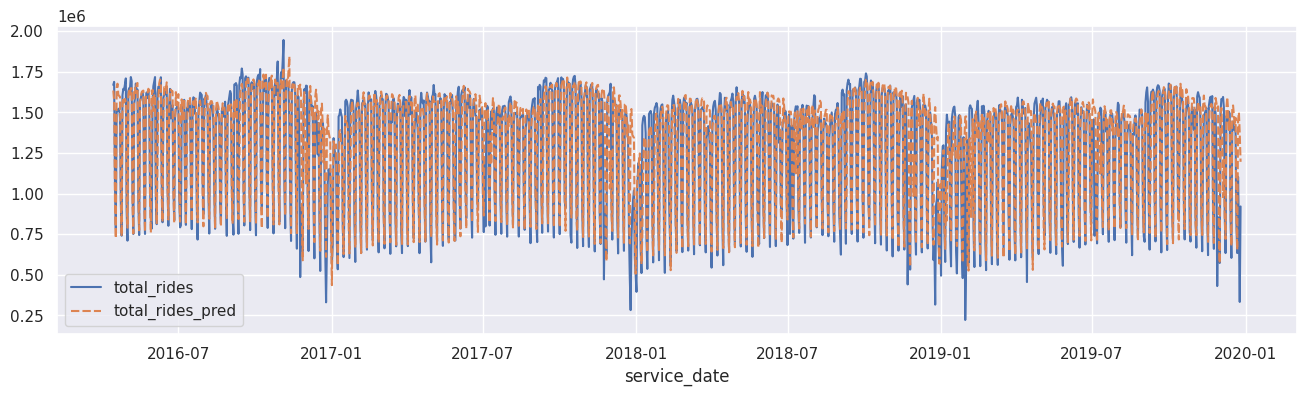

=== t+3 ===
R^2:  0.757
MAPE: 0.105
MAE:  98888.185



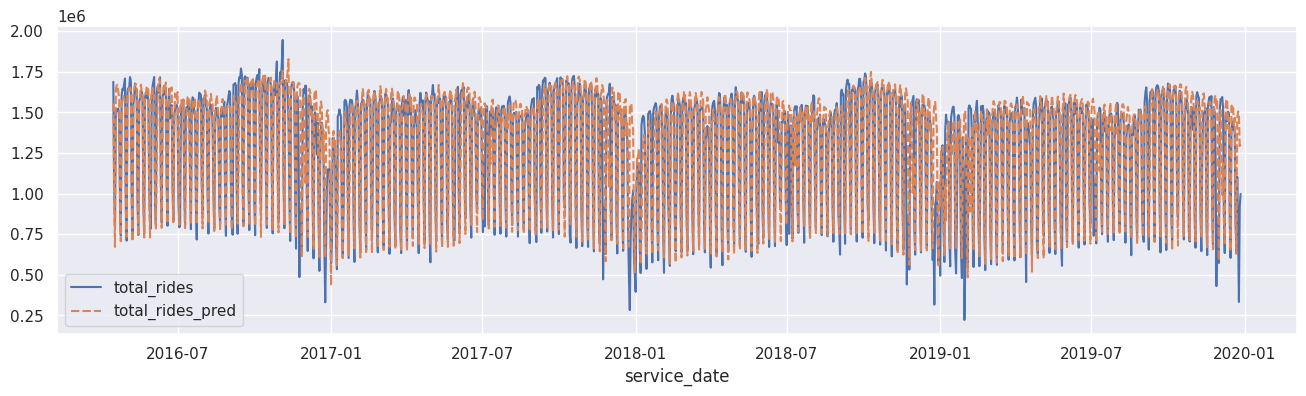

=== t+4 ===
R^2:  0.755
MAPE: 0.107
MAE:  99748.376



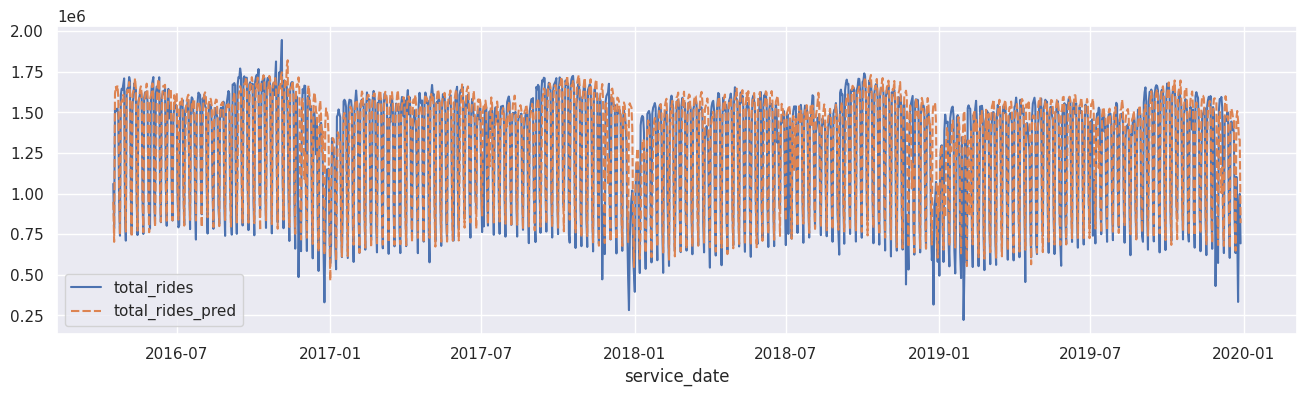

=== t+5 ===
R^2:  0.754
MAPE: 0.107
MAE:  100040.96



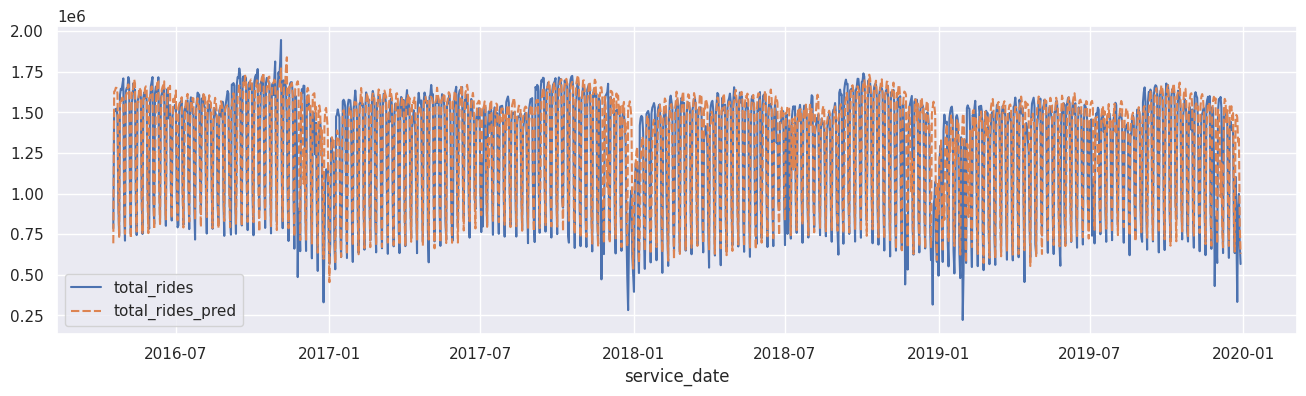

=== t+6 ===
R^2:  0.763
MAPE: 0.107
MAE:  97566.983



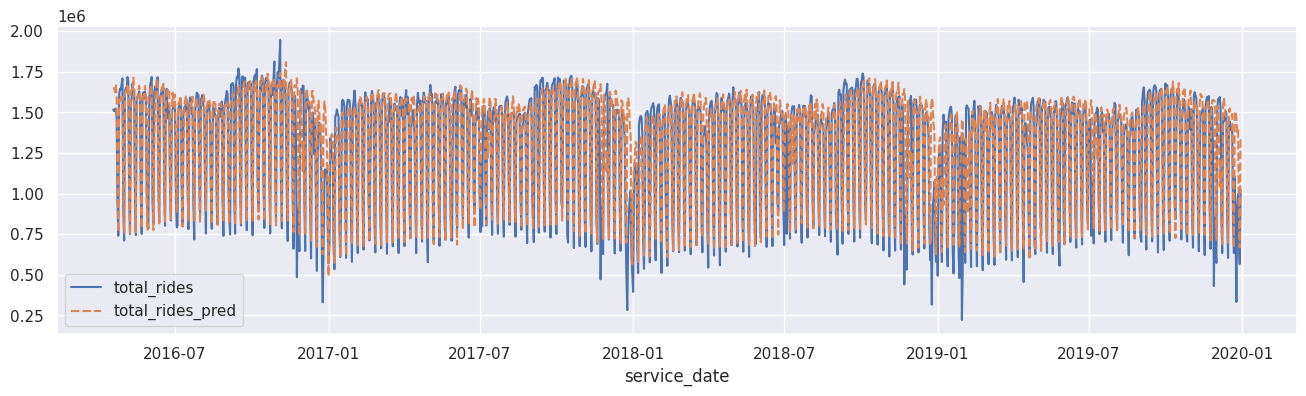

=== t+7 ===
R^2:  0.754
MAPE: 0.107
MAE:  98878.301



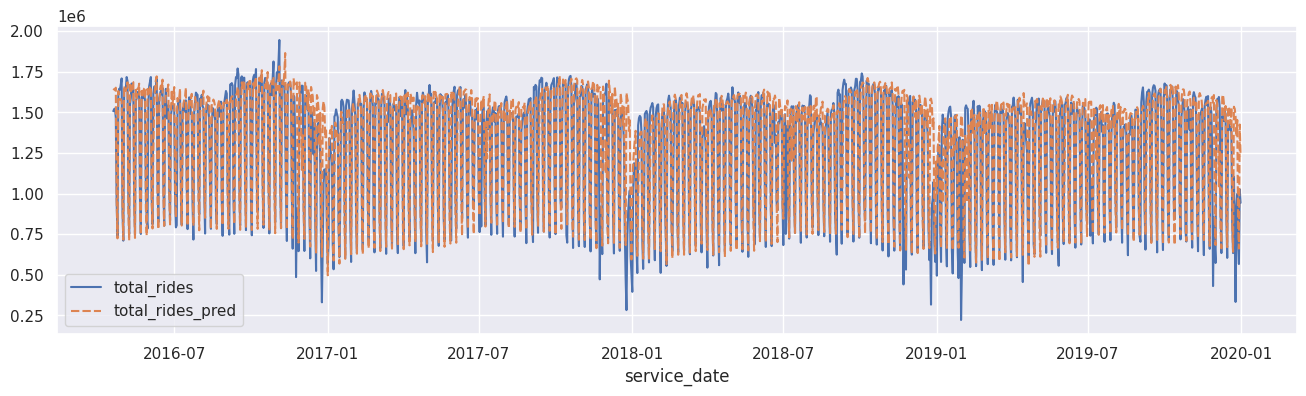

In [38]:
preds = cnn_model.predict(X_test)
y_pred_cnn = inverse_scale(preds)

evaluate(y_pred_cnn, df_test)

In [48]:
tf.saved_model.save(cnn_model, './cnn_export/')

## 2.5 Ensemble ML and Statistical Model

=== t+(1-7) ===
R^2:  0.816
MAPE: 0.089
MAE:  79019.608

=== t+1 ===
R^2:  0.852
MAPE: 0.078
MAE:  67917.274



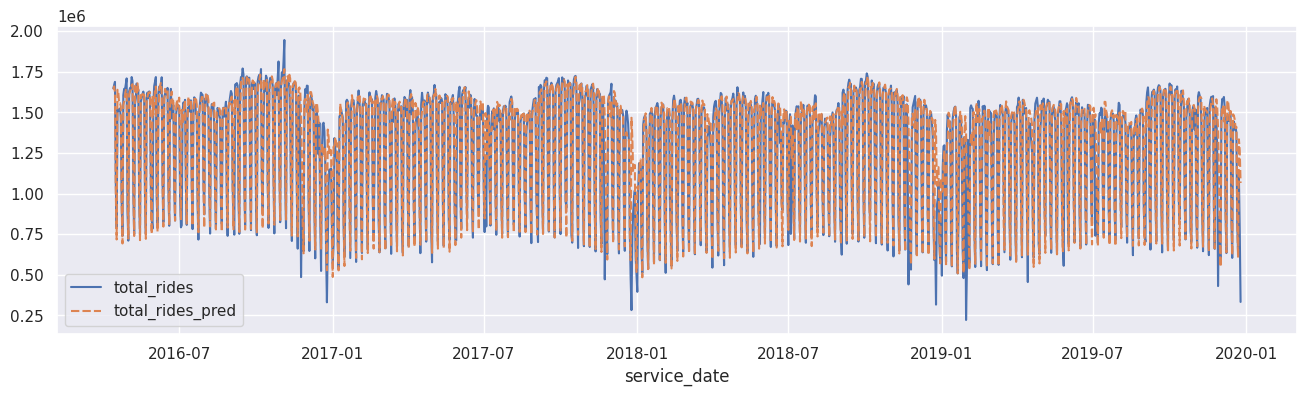

=== t+2 ===
R^2:  0.822
MAPE: 0.087
MAE:  76736.995



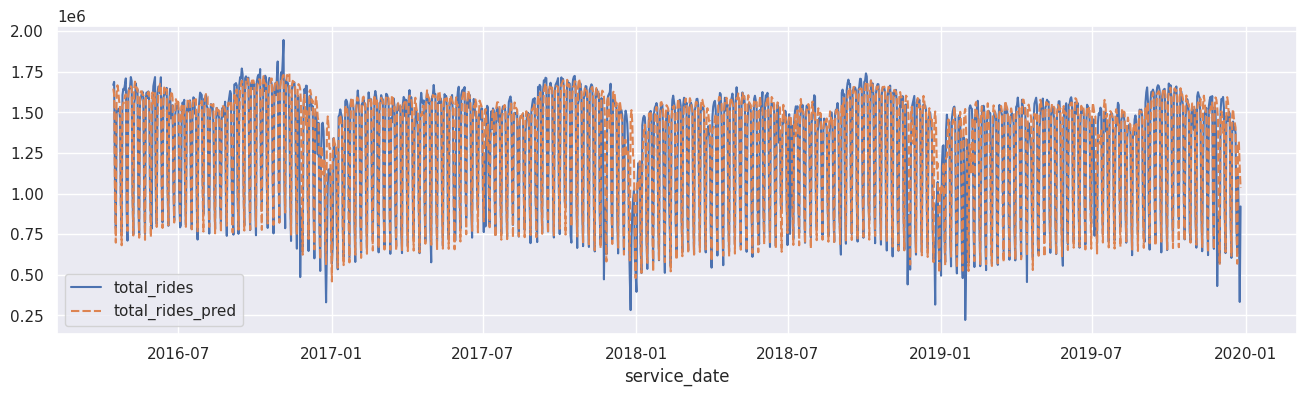

=== t+3 ===
R^2:  0.811
MAPE: 0.091
MAE:  80414.749



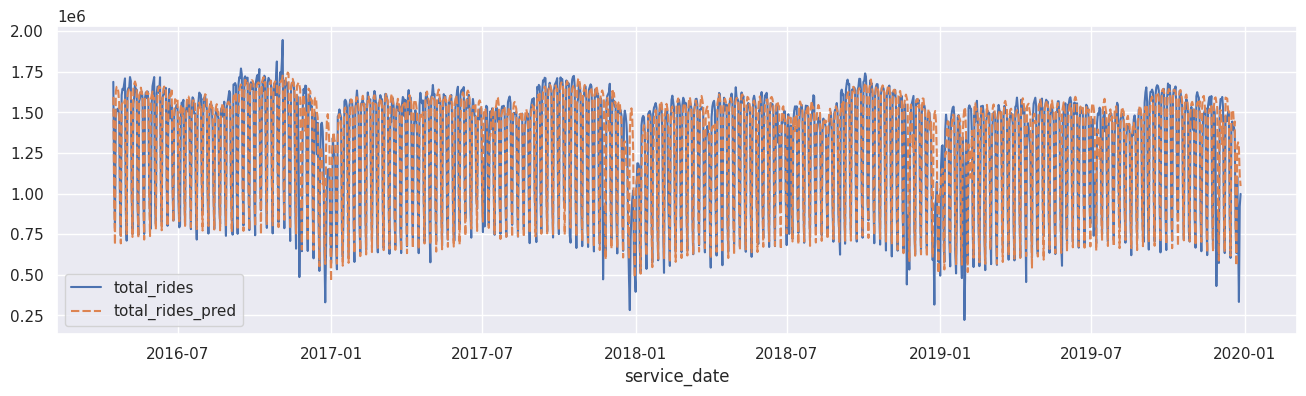

=== t+4 ===
R^2:  0.804
MAPE: 0.094
MAE:  83150.93



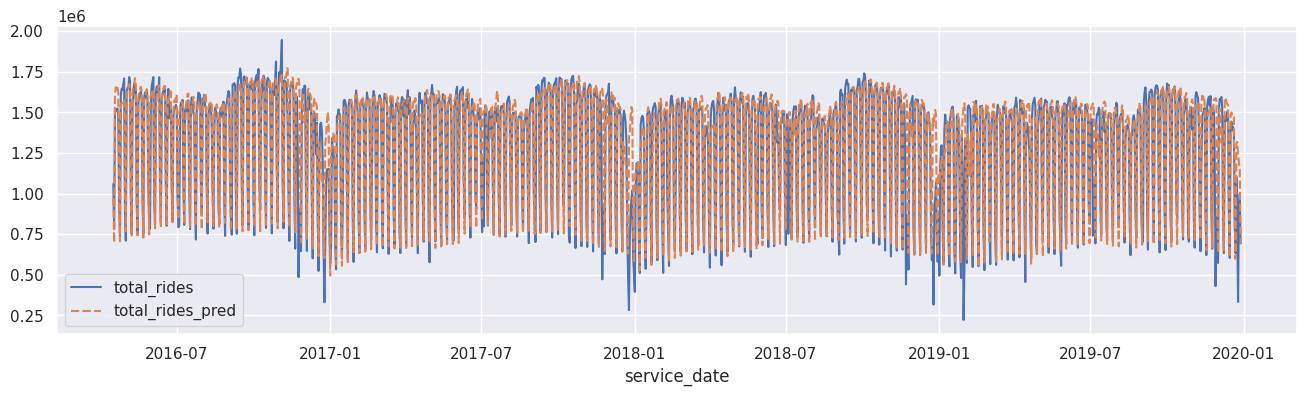

=== t+5 ===
R^2:  0.806
MAPE: 0.093
MAE:  82302.32



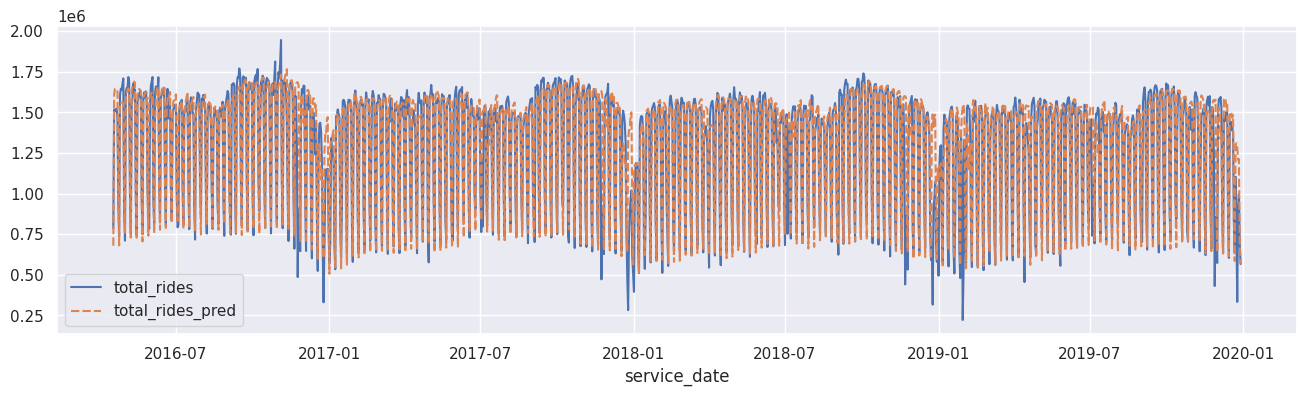

=== t+6 ===
R^2:  0.813
MAPE: 0.091
MAE:  80528.145



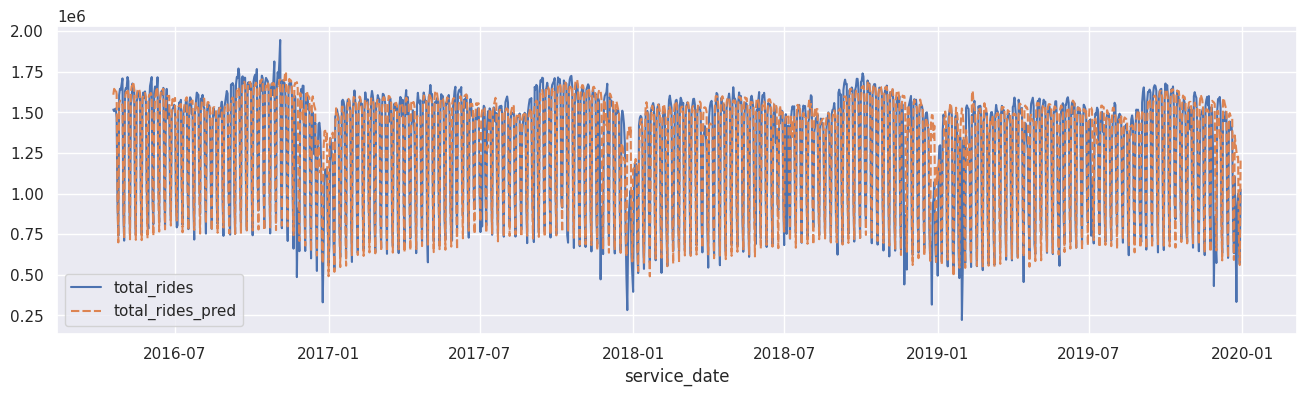

=== t+7 ===
R^2:  0.804
MAPE: 0.093
MAE:  82086.844



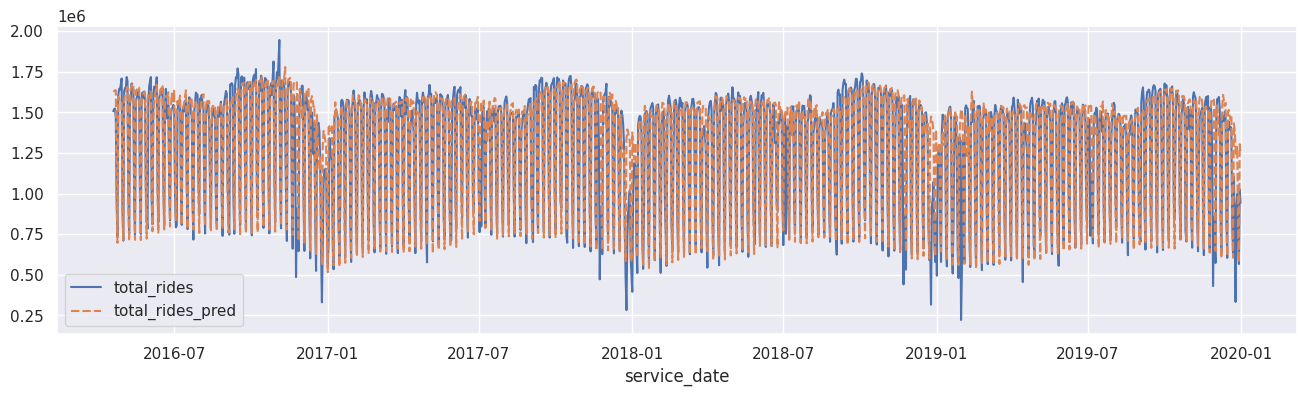

In [39]:
models = [y_pred_lstm, y_pred_cnn]
weights = [2, 1]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)

evaluate(y_pred_ensemble, df_test)